In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.18,
    zoom_range=0.18,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.18,
    height_shift_range=0.18
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(178, 218),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    'data/validation',
    target_size=(178, 218),
    batch_size=32,
    class_mode='binary'
)

Found 182337 images belonging to 2 classes.
Found 20260 images belonging to 2 classes.


In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(178, 218, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=2
)

Epoch 1/2
5698/5698 ━━━━━━━━━━━━━━━━━━━━ 18414s 3s/step - accuracy: 0.6353 - loss: 0.6397 - val_accuracy: 0.7168 - val_loss: 0.5419
Epoch 2/2
   1/5698 ━━━━━━━━━━━━━━━━━━━━ 4:30:42 3s/step - accuracy: 0.6562 - loss: 0.5591

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5698/5698 ━━━━━━━━━━━━━━━━━━━━ 4s 118us/step - accuracy: 0.6562 - loss: 0.5591 - val_accuracy: 0.7500 - val_loss: 0.3232


In [12]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

634/634 ━━━━━━━━━━━━━━━━━━━━ 1817s 3s/step - accuracy: 0.7262 - loss: 0.5307
Validation Accuracy: 72.96%


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import LeakyReLU
from keras import regularizers

In [ ]:

model_2 = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(160, 190, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=8,
    callbacks=[reduce_lr]
)

In [22]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

634/634 ━━━━━━━━━━━━━━━━━━━━ 306s 483ms/step - accuracy: 0.9409 - loss: 0.1609
Validation Accuracy: 94.03%


In [24]:
model.save('model.keras')

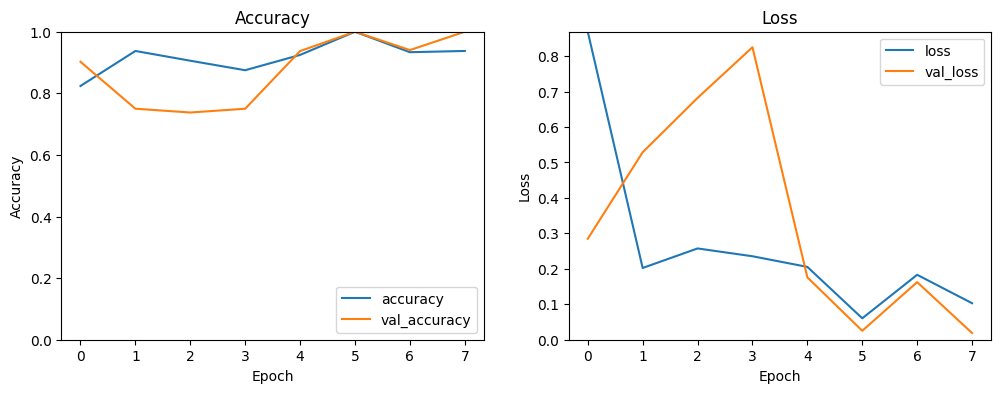

In [23]:
plt.figure(figsize=(12, 4))

# Точность
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy')

# Потери
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(max(history.history['loss']), max(history.history['val_loss']))])
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()